# HW4P2: Attention-based Speech Recognition

Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with attention. <br> <br>

HW Writeup: https://piazza.com/class_profile/get_resource/l37uyxe87cq5xn/lam1lcjjj0314e <br>
Kaggle competition link: https://www.kaggle.com/competitions/11-785-f22-hw4p2/ <br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Initial Set-up

In [ ]:
!nvidia-smi

Sat Dec  3 21:19:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb

# Import

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import pandas as pd
import numpy as np
import Levenshtein

import torch
import torchaudio
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gc
from torchsummaryX import summary
import wandb
from glob import glob

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
# TODO: Import drive if you are a colab user

# Config

In [ ]:
# Global config dict. Feel free to add or change if you want.
config = {
    'batch_size': 96,
    'epochs': 30,
    'lr': 1e-3
}

# Toy Data Setup

The toy dataset is very essential for you in this HW. The model which you will be building is complicated and you first need to make sure that it runs on the toy dataset. <br>
In other words, you need convergence - the attention diagonal. Take a look at the write-up for this. <br>
We have given you the following code to download the toy data and load it. You can use it the way it is. But be careful, the transcripts are different from the original data from kaggle. The toy dataset has phonemes but the actual data has characters.

In [ ]:
# !wget -q https://cmu.box.com/shared/static/wok08c2z2dp4clufhy79c5ee6jx3pyj9 --content-disposition --show-progress
# !wget -q https://cmu.box.com/shared/static/zctr6mvh7npfn01forli8n45duhp2g85 --content-disposition --show-progress
# !wget -q https://cmu.box.com/shared/static/m2oaek69145ljeu6srtbbb7k0ip6yfup --content-disposition --show-progress
# !wget -q https://cmu.box.com/shared/static/owrjy0tqra3v7zq2ru7mocy2djskydy9 --content-disposition --show-progress

f0176_mfccs_train.n 100%[===================>] 279.30M  9.07MB/s    in 32s     
f0176_mfccs_dev.npy 100%[===================>]  27.93M  12.2MB/s    in 2.3s    
f0176_hw3p2_train.n 100%[===================>]   7.02M  --.-KB/s    in 0.1s    
f0176_hw3p2_dev.npy 100%[===================>] 718.88K  --.-KB/s    in 0.01s   


In [ ]:
# Load the toy dataset
X_train = np.load("f0176_mfccs_train.npy")
X_valid = np.load("f0176_mfccs_dev.npy")
Y_train = np.load("f0176_hw3p2_train.npy")
Y_valid = np.load("f0176_hw3p2_dev.npy")

# This is how you actually need to find out the different trancripts in a dataset. 
# Can you think whats going on here? Why are we using a np.unique?
VOCAB_MAP           = dict(zip(np.unique(Y_valid), range(len(np.unique(Y_valid))))) 
VOCAB_MAP["[PAD]"]  = len(VOCAB_MAP)
VOCAB               = list(VOCAB_MAP.keys())

SOS_TOKEN = VOCAB_MAP["[SOS]"]
EOS_TOKEN = VOCAB_MAP["[EOS]"]
PAD_TOKEN = VOCAB_MAP["[PAD]"]

Y_train = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_train]
Y_valid = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_valid]

In [ ]:
# Dataset class for the Toy dataset
class ToyDataset(torch.utils.data.Dataset):

    def __init__(self, partition):

        if partition == "train":
            self.mfccs = X_train[:, :, :15]
            self.transcripts = Y_train

        elif partition == "valid":
            self.mfccs = X_valid[:, :, :15]
            self.transcripts = Y_valid

        assert len(self.mfccs) == len(self.transcripts)

        self.length = len(self.mfccs)

    def __len__(self):

        return self.length

    def __getitem__(self, i):

        x = torch.tensor(self.mfccs[i])
        y = torch.tensor(self.transcripts[i])

        return x, y

    def collate_fn(batch):

        x_batch, y_batch = list(zip(*batch))

        x_lens      = [x.shape[0] for x in x_batch] 
        y_lens      = [y.shape[0] for y in y_batch] 

        x_batch_pad = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value= EOS_TOKEN)
        y_batch_pad = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value= EOS_TOKEN) 
        
        return x_batch_pad, y_batch_pad, torch.tensor(x_lens), torch.tensor(y_lens)

# Kaggle Data

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"joonghochoi","key":"7420d9855539804c3a24a55d7add20dc"}') 
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Download the data
!kaggle competitions download -c 11-785-f22-hw4p2
!mkdir '/content/data'

!unzip -qo '11-785-f22-hw4p2.zip' -d '/content/data'

11-785-f22-hw4p2.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘/content/data’: File exists


# Dataset Class

In [ ]:
# These are the various characters in the transcripts of the datasetW
VOCAB = ['<sos>',   
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         '<eos>']

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

In [ ]:
# TODO: Create a dataset class which is exactly the same as HW3P2. You are free to reuse it. 
# The only change is that the transcript mapping is different for this HW.
# Note: We also want to retain SOS and EOS tokens in the transcript this time.

class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self,path,partition="train",train=True): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''
        # Load the directory and all files in them

        if partition=="train":
          self.train=train
          self.mfcc_dir=path+"/"+partition+"-clean-100/mfcc/"
          if self.train:
            self.transcript_dir=path+"/"+partition+"-clean-100/transcript/raw/"
          self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
          if self.train:
            self.transcript_files = sorted(os.listdir(self.transcript_dir))


        if partition=="dev":
          self.train=train
          self.mfcc_dir=path+"/"+partition+"-clean/mfcc/"
          if self.train:
            self.transcript_dir=path+"/"+partition+"-clean/transcript/raw/"          
          self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
          if self.train:
            self.transcript_files = sorted(os.listdir(self.transcript_dir))

        self.transform1=torchaudio.transforms.TimeMasking(time_mask_param=150)
        self.transform2=torchaudio.transforms.FrequencyMasking(freq_mask_param=6)

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files) 
        
        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS
        
        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
       

    def __len__(self):
        
        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        mfcc_path=self.mfcc_dir+self.mfcc_files[ind]
        mfcc=np.load(mfcc_path)
        mfcc=((mfcc-np.mean(mfcc,axis=0))/np.std(mfcc,axis=0))
        mfcc = torch.FloatTensor(mfcc)
        if self.train:
          path=self.transcript_dir+self.transcript_files[ind]
          phonemes=np.load(path)
          transcript=[VOCAB_MAP[item] for item in phonemes]
          transcript = np.array(transcript)
          transcript=torch.LongTensor(transcript)
  
        

        if self.train:
          mfcc=self.transform1(mfcc)
          mfcc=self.transform2(mfcc)
          return mfcc,transcript
          #return self.transform(mfcc)
          # return map_func(mfcc,self.transform),transcript
        else:
          mfcc=self.transform1(mfcc)
          mfcc=self.transform2(mfcc)
          return mfcc
          # return map_func(mfcc,self.transform)

    def collate_fn(batch):
        '''
        Input: output of get_item->tuple
        enumerate 

        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        batch_mfcc = [mfcc for mfcc,transcript in batch] # TODO
        # batch of output phonemes
        batch_transcript = [transcript for mfcc,transcript in batch] # TODO

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc = [len(mfcc) for mfcc in batch_mfcc] # TODO 

        batch_transcript_pad = pad_sequence(batch_transcript,batch_first=True) # TODO
        lengths_transcript = [len(transcript) for transcript in batch_transcript]# TODO

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

       

In [ ]:
# TODO: Similarly, create a test dataset class
# Test Dataloader
#TODO
class AudioDatasetTest(torch.utils.data.Dataset):
   
    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    def __init__(self,path,partition="test"): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''
        self.mfcc_dir=path+"/"+partition+"-clean/mfcc/"
        # Load the directory and all files in them
        
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files) 
        
        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS
        
        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
       

    def __len__(self):
        
        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''
        mfcc_path=self.mfcc_dir+self.mfcc_files[ind]
        mfcc=np.load(mfcc_path)
        mfcc=((mfcc-np.mean(mfcc,axis=0))/np.std(mfcc,axis=0)) #added
        mfcc = torch.FloatTensor(mfcc)
        
        return mfcc

    def collate_fn(batch):
        '''
        Input: output of get_item->tuple
        enumerate 

        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
        '''
        # batch of input mfcc coefficients
        batch_mfcc = [mfcc for mfcc in batch] # TODO
        # batch of output phonemes

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc = [len(mfcc) for mfcc in batch_mfcc] # TODO 

       

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)


# Dataset and Dataloaders

In [ ]:
# TODO: Create the datasets and dataloaders
# All these things are similar to HW3P2
# You can reuse the same code

# The sanity check for shapes also are similar
# Please remember that the only change in the dataset for this HW is the transcripts
# So you are expected to get similar shapes like HW3P2 (Pad, pack and Oh my!)

# Create objects for the dataset class
root = '/content/data/hw4p2' 

BATCH_SIZE=96

# train_data = ToyDataset(partition="train") #TODO
# val_data = ToyDataset(partition="valid")

train_data = AudioDataset(path=root,partition="train",train=True,) #TODO
val_data = AudioDataset(path=root,partition="dev",train=True,) # TODO : You can either use the same class with some modifications or make a new one :)
test_data = AudioDatasetTest(path=root,partition="test") #TODO

# Do NOT forget to pass in the collate function as parameter while creating the dataloader

# train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True, collate_fn=ToyDataset.collate_fn)
# val_loader = torch.utils.data.DataLoader(val_data,batch_size=BATCH_SIZE, shuffle=True, collate_fn=ToyDataset.collate_fn)


train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True, collate_fn=AudioDataset.collate_fn)
val_loader = torch.utils.data.DataLoader(val_data,batch_size=BATCH_SIZE, shuffle=True, collate_fn=AudioDataset.collate_fn)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=False,collate_fn=AudioDatasetTest.collate_fn)
print("Batch size: ", BATCH_SIZE)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
#print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  96
Train dataset samples = 28539, batches = 298
Val dataset samples = 2703, batches = 29


In [ ]:
print(train_data.collate_fn)
example_batch=next(iter(train_loader)) #works for full dataset, but not toy dataset
print(example_batch[0].shape)

<bound method AudioDataset.collate_fn of <__main__.AudioDataset object at 0x7fd7f98ee690>>
torch.Size([96, 1677, 15])


# Model

In this section you will be building the LAS model from scratch. Before starting to code, please read the writeup, paper and understand the following parts completely.<br>
- Pyramidal Bi-LSTM 
- Listener
- Attention
- Speller

After getting a good grasp of the workings of these modules, start coding. Follow the TODOs carefully. We will also be adding some extra features to the attention mechanism like keys and values which are not originally present in LAS. So we will be creating a hybrid network based on LAS and Attention is All You Need.


## Encoder

### Pyramidal Bi-LSTM

In [ ]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm =torch.nn.LSTM(input_size,hidden_size,bidirectional=True,batch_first=True) # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        out,length=pad_packed_sequence(x_packed,batch_first=True)
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        x,x_lens=self.trunc_reshape(out,length)
        # TODO: Pack Padded Sequence. What output(s) would you get?
        packed_input=pack_padded_sequence(x,x_lens,batch_first=True,enforce_sorted=False)
        # TODO: Pass the sequence through bLSTM
        output,(h_n,c_n)=self.blstm(packed_input) #still output is packed sequence
        # What do you return?
        

        return output

    def trunc_reshape(self, x, x_lens): 
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # TODO: Reduce lengths by the same downsampling factor

        B,T,N     =x.shape
        factor    =2
        new_T     =T//factor

        x         =x[:,:new_T*factor,:]
        x         =x.reshape(B,new_T,N*factor)

        x_lens    =torch.clamp(x_lens,max=x.shape[1])
        
        return x, x_lens

### Listener

In [ ]:
#source: https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/nn/lock_dropout.html
class LockedDropout(torch.nn.Module):
    """ LockedDropout applies the same dropout mask to every time step.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.5):
        self.p = p
        super().__init__()

    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [sequence length, batch size, rnn hidden size]): Input to
                apply dropout too.
        """
        # if not self.training or not self.p:
        #     return x
        # x = x.clone()
        # mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        # mask = mask.div_(1 - self.p)
        # mask = mask.expand_as(x)
        # return x * mask

        if not self.training or not self.p:
            return x
        else:
          x,lx=pad_packed_sequence(x,batch_first=True)
          x = x.clone()
          mask = x.new_empty(x.size(0),1 , x.size(2), requires_grad=False).bernoulli_(1 - self.p)
          mask = mask.div_(1 - self.p)
          mask = mask.expand_as(x)
          x=x*mask
          x=pack_padded_sequence(x,lx,batch_first=True,enforce_sorted=False)
          return x 


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'



In [ ]:
class Listener(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Listener, self).__init__()

        # The first LSTM at the very bottom
        self.base_lstm = torch.nn.LSTM(input_size, encoder_hidden_size, bidirectional=True, batch_first=True)#TODO: Fill this up

        self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
            # TODO: Fill this up with pBLSTMs - What should the input_size be? 
            # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
            # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
            # ...
            # ...
            pBLSTM(4*encoder_hidden_size,encoder_hidden_size),
            LockedDropout(0.15),
            pBLSTM(4*encoder_hidden_size,encoder_hidden_size),
            LockedDropout(0.15),
            pBLSTM(4*encoder_hidden_size,encoder_hidden_size),
        )
         
    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        
        # TODO: Pack Padded Sequence
        packed=pack_padded_sequence(x,x_lens,batch_first=True,enforce_sorted=False)
        # TODO: Pass it through the first LSTM layer (no truncation)
        out,(h_n,c_n)=self.base_lstm(packed)
        # TODO: Pad Packed Sequence
        
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        out=self.pBLSTMs(out)
        # for layer in self.pBLSTMs:
        #   out=layer(out)
        out,out_length=pad_packed_sequence(out,batch_first=True)

        # Remember the number of output(s) each function returns
        encoder_outputs=out
        encoder_lens=out_length
        return encoder_outputs, encoder_lens

In [ ]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break 

torch.Size([96, 1670, 15]) torch.Size([96, 281]) torch.Size([96]) torch.Size([96])


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = Listener(input_size=15, encoder_hidden_size=256) # TODO: Initialize Listener
encoder.to(device)
print(encoder)
#summary(encoder, example_batch[0].to(DEVICE), example_batch[3]) typo 
summary(encoder,x.to(device), lx)
del encoder

Listener(
  (base_lstm): LSTM(15, 256, batch_first=True, bidirectional=True)
  (pBLSTMs): Sequential(
    (0): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
    (1): LockedDropout(p=0.15)
    (2): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
    (3): LockedDropout(p=0.15)
    (4): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
  )
)
                          Kernel Shape   Output Shape     Params Mult-Adds
Layer                                                                     
0_base_lstm                          -  [115741, 512]   559.104k  555.008k
1_pBLSTMs.0.LSTM_blstm               -   [74664, 512]  2.625536M  2.62144M
2_pBLSTMs.LockedDropout_1            -   [74664, 512]          -         -
3_pBLSTMs.2.LSTM_blstm               -   [39538, 512]  2.625536M  2.62144M
4_pBLSTMs.LockedDropout_3            -   [39538, 512]          -         -
5_pBLSTMs.4.LSTM_blstm       

/usr/local/lib/python3.7/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


## Attention (Attend)

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

In [ ]:
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(torch.nn.Module):
    '''
    Attention is calculated using the key, value (from encoder hidden states) and query from decoder.
    Here are different ways to compute attention and context:

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    masked_raw_weights  = mask(raw_weights) # mask out padded elements with big negative number (e.g. -1e9 or -inf in FP16)
    attention           = softmax(masked_raw_weights)
    context             = bmm(attention, value)
    
    At the end, you can pass context through a linear layer too.

    '''
    
    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size):
        super(Attention, self).__init__()

        self.key_projection     = torch.nn.Linear(2*encoder_hidden_size, projection_size)# TODO: Define an nn.Linear layer which projects the encoder_hidden_state to keys
        self.value_projection   = torch.nn.Linear(2*encoder_hidden_size, projection_size)# TODO: Define an nn.Linear layer which projects the encoder_hidden_state to value
        self.query_projection   = torch.nn.Linear(decoder_output_size, projection_size)# TODO: Define an nn.Linear layer which projects the decoder_output_state to query
        # Optional : Define an nn.Linear layer which projects the context vector

        self.projection_size=projection_size
        self.softmax            = torch.nn.Softmax(dim=1)# TODO: Define a softmax layer. Think about the dimension which you need to apply 
        # Tip: What is the shape of energy? And what are those?

    # As you know, in the attention mechanism, the key, value and mask are calculated only once.
    # This function is used to calculate them and set them to self
    def set_key_value_mask(self, encoder_outputs, encoder_lens):
    
        _, encoder_max_seq_len, _ = encoder_outputs.shape

        self.key      = self.key_projection(encoder_outputs)# TODO: Project encoder_outputs using key_projection to get keys
        self.value    = self.value_projection(encoder_outputs)# TODO: Project encoder_outputs using value_projection to get values

        # encoder_max_seq_len is of shape (batch_size, ) which consists of the lengths encoder output sequences in that batch
        # The raw_weights are of shape (batch_size, timesteps)

        # TODO: To remove the influence of padding in the raw_weights, we want to create a boolean mask of shape (batch_size, timesteps) 
        # The mask is False for all indicies before padding begins, True for all indices after.

        
        mask= torch.arange(encoder_max_seq_len).unsqueeze(0) >= encoder_lens.unsqueeze(1)
        self.padding_mask     =  mask.to(DEVICE) # TODO: You want to use a comparison between encoder_max_seq_len and encoder_lens to create this mask. 
        # (Hint: Broadcasting gives you a one liner)
        
        #if encoder_lens=7 and encoder_max_seq_len=5, 5 true and 2 False.
        #B,T=encoder_hidden_size[0],encoder_hidden_size[1] correct
        #However, don'[t need since encoder_lens given ]

    def forward(self, decoder_output_embedding):
        # key   : (batch_size, timesteps, projection_size)
        # value : (batch_size, timesteps, projection_size)
        # query : (batch_size, projection_size)

        self.query         = self.query_projection(decoder_output_embedding)# TODO: Project the query using query_projection

        # Hint: Take a look at torch.bmm for the products below 

        raw_weights= torch.bmm(self.key, torch.unsqueeze(self.query, 2))# TODO: Calculate raw_weights which is the product of query and key, and is of shape (batch_size, timesteps)
        raw_weights = torch.squeeze(raw_weights, dim= 2)

        #torch.bmm for key and query. 

        # print("mask ",mask)
        # print("raw_weights",raw_weights)

        raw_weights.masked_fill_(self.padding_mask, float('-inf')) #inplace operation
        # masked_raw_weights = raw_weights.masked_fill_(mask, -1e9)# TODO: Mask the raw_weights with self.padding_mask. 
        #RuntimeError: value cannot be converted to type at::Half without overflow: -1e+09

        # Take a look at pytorch's masked_fill_ function (You want the fill value to be a big negative number for the softmax to make it close to 0)
        # attention_weights  = self.softmax(masked_raw_weights/np.sqrt(self.query.shape[1]))# TODO: Calculate the attention weights, which is the softmax of raw_weights
        attention_weights  = self.softmax(raw_weights/np.sqrt(self.key.shape[2]))
        #use projection or prediction size under sqrt

        #attention_weights  = torch.nn.functional.softmax(masked_raw_weights, dim=1)# TODO: Calculate the attention weights, which is the softmax of raw_weights
        context            = torch.bmm(torch.unsqueeze(attention_weights, 1), self.value)# TODO: Calculate the context - it is a product between attention_weights and value
        context            = torch.squeeze(context, dim= 1)
        # Hint: You might need to use squeeze/unsqueeze to make sure that your operations work with bmm

        return context, attention_weights # Return the context, attention_weights

## Decoder

### Speller

In [ ]:
#self.lstem_cells, forward(context)
class Speller(torch.nn.Module):

    def __init__(self, embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module= None):
        super().__init__()

        self.vocab_size         = vocab_size

        self.embedding          = torch.nn.Embedding(vocab_size,embed_size,padding_idx=EOS_TOKEN)# TODO: Initialize the Embedding Layer (Use the nn.Embedding Layer from torch), make sure you set the correct padding_idx  
        #padding_idx
        #print("embed_size+decoder_output_size",embed_size+decoder_output_size)
        self.lstm_cells         = torch.nn.Sequential(
                                # Create Two LSTM Cells as per LAS Architecture
                                # What should the input_size of the first LSTM Cell? 
                                # Hint: It takes in a combination of the character embedding and context from attention
                                torch.nn.LSTMCell(embed_size+attention_module.projection_size,decoder_hidden_size),
                                #torch.nn.Dropout(p=0.2),
                                torch.nn.LSTMCell(decoder_hidden_size,decoder_output_size)
                                )
    
                                # We are using LSTMCells because process individual time steps inputs and not the whole sequence.
                                # Think why we need this in terms of the query

        #self.char_prob          = torch.nn.Linear(decoder_output_size,vocab_size)# TODO: Initialize the classification layer to generate your probability distribution over all characters
        self.char_prob          = torch.nn.Linear(attention_module.projection_size+attention_module.projection_size,vocab_size)
        #self.attention.projection_size

        """
        self.query_projection   = torch.nn.Linear(decoder_output_size, projection_size)

        self.query         = self.query_projection(decoder_output_embedding)#
        
        context                 = torch.zeros((batch_size,self.attention.projection_size)).to(device)

        output_embedding     = torch.cat([self.attention.query,context],dim=1)# TODO: Concatenate the projected query with context for the output embedding
            #or I can use attention.query or decoder_output_embedding
        """
        self.char_prob.weight   = self.embedding.weight # Weight tying. Using same weights to prevent overfitting

        self.attention          = attention_module
        self.dropout=torch.nn.Dropout(p=0.2)

    
    def forward(self, encoder_outputs, encoder_lens, y = None, tf_rate = 1): 

        '''
        Args: 
            embedding: Attention embeddings 
            hidden_list: List of Hidden States for the LSTM Cells
        ''' 

        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape

        if self.training:
            timesteps     = y.shape[1] # The number of timesteps is the sequence of length of your transcript during training
            label_embed   = self.embedding(y) # Embeddings of the transcript, when we want to use teacher forcing
        else:
            timesteps     = 600 # 600 is a design choice that we recommend, however you are free to experiment.
        

        # INITS
        predictions     = []

        # Initialize the first character input to your decoder, SOS
        char            = torch.full((batch_size,), fill_value=SOS_TOKEN, dtype= torch.long).to(DEVICE) 

        # Initialize a list to keep track of LSTM Cell Hidden and Cell Memory States, to None
        hidden_states   = [None]*len(self.lstm_cells) 

        if self.attention != None:
            self.attention.set_key_value_mask(encoder_outputs, encoder_lens)

        attention_plot          = []
        context                 = self.attention.value[:,0,:]#torch.zeros((batch_size,self.attention.projection_size)).to(device)# TODO: Initialize context (You have a few choices, refer to the writeup )
        attention_weights       = torch.zeros(batch_size, encoder_max_seq_len) # Attention Weights are zero if not using Attend Module

        # Set Attention Key, Value, Padding Mask just once
        

        #print("char ",char)
        for t in range(timesteps):
            
            #char_embed = label_embed[:,t]
            char_embed = self.embedding(char)
            #TODO: Generate the embedding for the character at timestep t

            if self.training and t > 0:
                # TODO: We want to decide which embedding to use as input for the decoder during training
                # We can use the embedding of the transcript character or the embedding of decoded/predicted character, from the previous timestep 
                # Using the embedding of the transcript character is teacher forcing, it is very important for faster convergence
                # Use a comparison between a random probability and your teacher forcing rate, to decide which embedding to use
                val=np.random.random_sample()
                if val<tf_rate:
                  char_embed = label_embed[:,t-1]
      
            decoder_input_embedding = torch.cat([char_embed,context],dim=1)# TODO: What do we want to concatenate as input to the decoder? (Use torch.cat)
            
            # Loop over your lstm cells
            # Each lstm cell takes in an embedding 
            for i in range(len(self.lstm_cells)):
                # An LSTM Cell returns (h,c) -> h = hidden state, c = cell memory state
                # Using 2 LSTM Cells is akin to a 2 layer LSTM looped through t timesteps 
                # The second LSTM Cell takes in the output hidden state of the first LSTM Cell (from the current timestep) as Input, along with the hidden and cell states of the cell from the previous timestep
                
                #print("decoder input embedding",decoder_input_embedding.shape)
                # print("hidden states[i]",hidden_states[i].shape)
                #correct
                #hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i]) 
                
                
                #(h, c) = lstmcell(h, hiddens)
                  # h = dropout(h)
                  # hiddens = (h, c) 
                
                (h,c)=self.lstm_cells[i](decoder_input_embedding, hidden_states[i]) 
                h=self.dropout(h)
                hidden_states[i]=(h,c)
                decoder_input_embedding = hidden_states[i][0]

            # The output embedding from the decoder is the hidden state of the last LSTM Cell
            decoder_output_embedding = hidden_states[-1][0]

            # We compute attention from the output of the last LSTM Cell
            if self.attention != None:
                context, attention_weights = self.attention(decoder_output_embedding) # The returned query is the projected query

            attention_plot.append(attention_weights[0].detach().cpu())

            output_embedding     = torch.cat([self.attention.query,context],dim=1)# TODO: Concatenate the projected query with context for the output embedding
            #or I can use attention.query or decoder_output_embedding

            # Hint: How can you get the projected query from attention
            # If you are not using attention, what will you use instead of query?
            #

            char_prob            = self.char_prob(output_embedding) #shape:batch size x probability
            
            # Append the character probability distribution to the list of predictions 
            predictions.append(char_prob)
            
            char = torch.argmax(char_prob,dim=1) # TODO: Get the predicted character for the next timestep from the probability distribution 
            #do torch argmax with char_prob
            # (Hint: Use Greedy Decoding for starters)

        attention_plot  = torch.stack(attention_plot, dim=0) # TODO: Stack list of attetion_plots 
        #attention_plot  = torch.stack(attention_plot, dim=1)
        predictions     = torch.stack(predictions, dim=1)# TODO: Stack list of predictions 
        #predictions     = torch.stack(predictions, dim=0)
        #each item in predictions has shape of BxT
        

        return predictions, attention_plot

## Sequence-to-Sequence Model

### LAS

In [ ]:
class LAS(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, 
                 vocab_size, embed_size,
                 decoder_hidden_size, decoder_output_size,
                 projection_size= 128):
        
        super(LAS, self).__init__()

        self.encoder        = Listener(input_size, encoder_hidden_size)# TODO: Initialize Encoder
        attention_module    = Attention(encoder_hidden_size, decoder_output_size, projection_size)# TODO: Initialize Attention
        self.decoder        = Speller(embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module) # TODO: Initialize Decoder, make sure you pass the attention module 

    def forward(self, x, x_lens, y = None, tf_rate = 1):

        encoder_outputs, encoder_lens = self.encoder(x, x_lens) # from Listener
        predictions, attention_plot = self.decoder(encoder_outputs, encoder_lens, y, tf_rate)
        
        return predictions, attention_plot

# Training Setup

## Model Setup










In [ ]:
example_batch=next(iter(train_loader)) #works for full dataset, but not toy dataset
print(example_batch[0].shape)

torch.Size([96, 1701, 15])


In [ ]:
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    print(VOCAB)
    print(SOS_TOKEN)
    break 

torch.Size([96, 1678, 15]) torch.Size([96, 322]) torch.Size([96]) torch.Size([96])
['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>']
0


In [ ]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Decoder Output Dimension of 128
# Attention Projection Size of 128
# Feel Free to Experiment with this 


#43 for toy
model = LAS(
    input_size=15, encoder_hidden_size=256, 
                 vocab_size=len(VOCAB), embed_size=256,
                 decoder_hidden_size=512, decoder_output_size=128,
                 projection_size= 128
    # Initialize your model 
    # Read the paper and think about what dimensions should be used
    # You can experiment on these as well, but they are not requried for the early submission
    # Remember that if you are using weight tying, some sizes need to be the same
)

model = model.to(DEVICE)
print(model)

#replace example_Batch with what? x, y, lx, ly = data #ex batch0-3 
summary(model, 
        x= example_batch[0].to(DEVICE), 
        x_lens= example_batch[3], 
        y= example_batch[1].to(DEVICE))
# summary(model, 
#         x= x.to(DEVICE), 
#         x_lens= lx.to(DEVICE), 
#         y= y.to(DEVICE)
#         )

LAS(
  (encoder): Listener(
    (base_lstm): LSTM(15, 256, batch_first=True, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
      (1): LockedDropout(p=0.15)
      (2): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
      (3): LockedDropout(p=0.15)
      (4): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
    )
  )
  (decoder): Speller(
    (embedding): Embedding(30, 256, padding_idx=29)
    (lstm_cells): Sequential(
      (0): LSTMCell(384, 512)
      (1): LSTMCell(512, 128)
    )
    (char_prob): Linear(in_features=256, out_features=30, bias=True)
    (attention): Attention(
      (key_projection): Linear(in_features=512, out_features=128, bias=True)
      (value_projection): Linear(in_features=512, out_features=128, bias=True)
      (query_projection): Linear(in_features=128, out_features=128, bias=True)
    

/usr/local/lib/python3.7/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                               Kernel Shape  Output Shape  \
Layer                                                                       
0_encoder.LSTM_base_lstm                                  -  [17063, 512]   
1_encoder.pBLSTMs.0.LSTM_blstm                            -  [13552, 512]   
2_encoder.pBLSTMs.LockedDropout_1                         -  [13552, 512]   
3_encoder.pBLSTMs.2.LSTM_blstm                            -   [7431, 512]   
4_encoder.pBLSTMs.LockedDropout_3                         -   [7431, 512]   
...                                                     ...           ...   
2532_decoder.lstm_cells.LSTMCell_1                        -     [96, 128]   
2533_decoder.Dropout_dropout                              -     [96, 128]   
2534_decoder.attention.Linear_query_projection   [128, 128]     [96, 128]   
2535_decoder.attention.Softmax_softmax                    -      [96, 39]   
2536_decoder.Linear_char_prob                     [256, 30]      [96, 30]   

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.LSTM_base_lstm,-,"[17063, 512]",559104.0,555008.0
1_encoder.pBLSTMs.0.LSTM_blstm,-,"[13552, 512]",2625536.0,2621440.0
2_encoder.pBLSTMs.LockedDropout_1,-,"[13552, 512]",NaN,NaN
3_encoder.pBLSTMs.2.LSTM_blstm,-,"[7431, 512]",2625536.0,2621440.0
4_encoder.pBLSTMs.LockedDropout_3,-,"[7431, 512]",NaN,NaN
...,...,...,...,...
2532_decoder.lstm_cells.LSTMCell_1,-,"[96, 128]",NaN,327680.0
2533_decoder.Dropout_dropout,-,"[96, 128]",NaN,NaN
2534_decoder.attention.Linear_query_projection,"[128, 128]","[96, 128]",NaN,16384.0


In [ ]:
print(len(VOCAB))


30


## Optimizer, Scheduler, Loss

In [ ]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)
criterion   = torch.nn.CrossEntropyLoss(reduction='none') # Why are we using reduction = 'none' ? . returns matrix
scaler      = torch.cuda.amp.GradScaler()

optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               mode='min',  #min for minimising distance
                                                               factor=0.2,
                                                               patience=1,
                                                               min_lr=1e-6,
                                                               verbose=True)
# Optional: Create a custom class for a Teacher Force Schedule 

# Levenshtein Distance

In [ ]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        #dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset 
        dist      += Levenshtein.distance(y_sliced, pred_sliced)

    #if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        # print("Ground Truth : ", y_string)
        # print("Prediction   : ", pred_string)
        # print("Ground Truth : ", y_sliced)
        # print("Prediction   : ", pred_sliced)    dist/=batch_size
    return dist/batch_size

# Train and Evaluate

In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            predictions, attention_plot = model(x, lx, y= y, tf_rate= teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # print("prediction shape in train",predictions.shape)
            # print("y shape in train",y.shape)

            B,T,N=np.shape(predictions)

            new_pred=predictions.view(-1,N)
            new_y=y.view(-1)

            loss= criterion(new_pred,new_y)# TODO: Cross Entropy Loss
            
            #padding part of transcript only so only remove ly. 

            mask=torch.arange(y.shape[1]).unsqueeze(0) < ly.unsqueeze(1) #not <=

            mask        = mask # TODO: Create a boolean mask using the lengths of your transcript that remove the influence of padding indices (in transcripts) in the loss 

            mask=mask.to(DEVICE)
            mask=mask.view(-1)

            masked_loss =  torch.sum(loss*mask)/torch.sum(mask)# Product between the mask and the loss, divided by the mask's sum. Hint: You may want to reshape the mask too 
            perplexity  = torch.exp(masked_loss) # Perplexity is defined the exponential of the loss

            running_loss        += masked_loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(masked_loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [ ]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    with torch.no_grad():
      for i, (x, y, lx, ly) in enumerate(dataloader):

          x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

          with torch.inference_mode():
              predictions, attentions = model(x, lx, y = None)

          # Greedy Decoding
          greedy_predictions   =  torch.argmax(predictions,dim=2) # TODO: How do you get the most likely character from each distribution in the batch?

          # Calculate Levenshtein Distance
          running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False)
          batch_bar.set_postfix(
              dist="{:.04f}".format(running_lev_dist/(i+1)))
          batch_bar.update()

          del x, y, lx, ly
          torch.cuda.empty_cache()

      batch_bar.close()
      running_lev_dist /= len(dataloader)

    return running_lev_dist#, running_loss, running_perplexity, 

# Experiments

In [ ]:
# Optional: Load your best model Checkpoint here
PATH='./second_attempt.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
best_val_dist = checkpoint['val_dist']
past_valid_dist = checkpoint['val_dist']
0.0010

print(best_val_dist)

30.971982758620687


In [ ]:
print(optimizer) #previously 0.001
optimizer.param_groups[0]['lr']=0.008
print(optimizer)


Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 5e-06
)
Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.008
    weight_decay: 5e-06
)



Epoch: 29/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

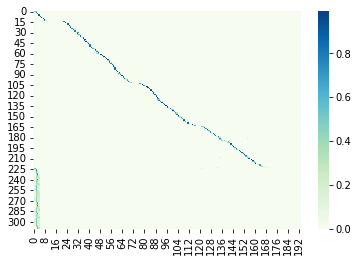

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.24678842128323228
Validation distance: 31.05783045977012

Epoch: 30/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

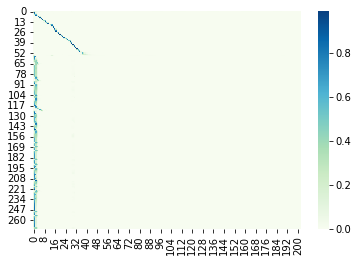

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.24879265401587392
Validation distance: 29.87887931034482

Epoch: 31/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

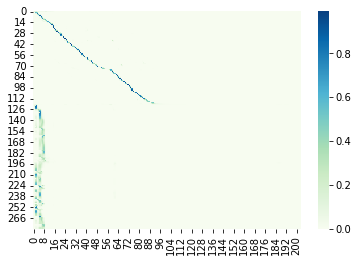

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.24594308765942618
Validation distance: 30.649856321839085

Epoch: 32/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

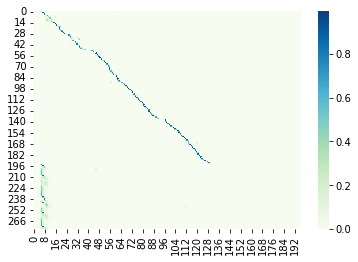

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch     4: reducing learning rate of group 0 to 1.6000e-03.
running_loss 0.24235175324966443
Validation distance: 30.47909482758621

Epoch: 33/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

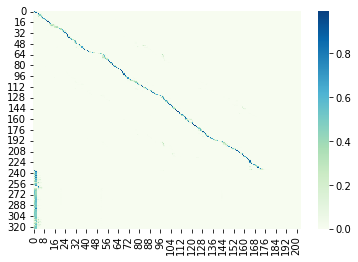

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.24763547364097313
Validation distance: 31.337571839080457

Epoch: 34/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

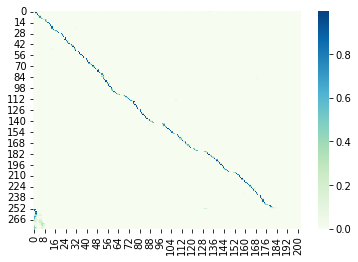

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch     6: reducing learning rate of group 0 to 3.2000e-04.
running_loss 0.2493159950479565
Validation distance: 31.296551724137927

Epoch: 35/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

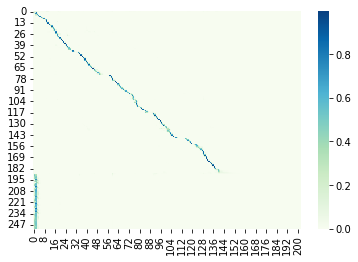

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.24649776033307083
Validation distance: 30.301652298850566

Epoch: 36/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

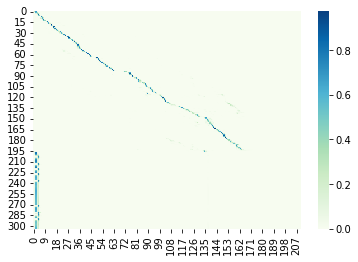

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch     8: reducing learning rate of group 0 to 6.4000e-05.
running_loss 0.2478696624904671
Validation distance: 31.310775862068972

Epoch: 37/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

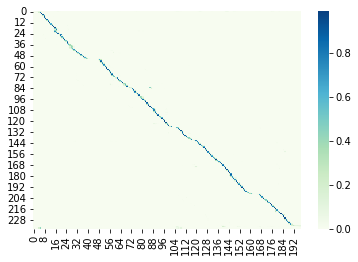

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.24449922164414553
Validation distance: 30.101508620689657

Epoch: 38/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

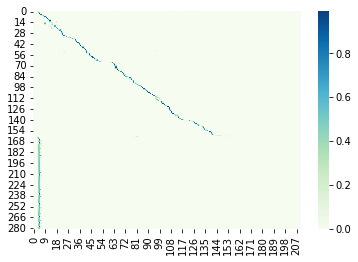

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    10: reducing learning rate of group 0 to 1.2800e-05.
running_loss 0.2459529967316045
Validation distance: 29.914152298850574

Epoch: 39/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

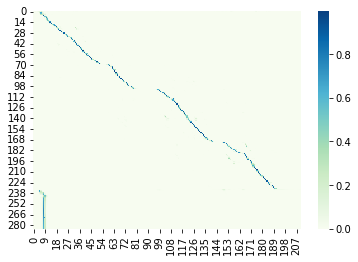

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.24764803056948936
Validation distance: 30.59619252873563

Epoch: 40/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

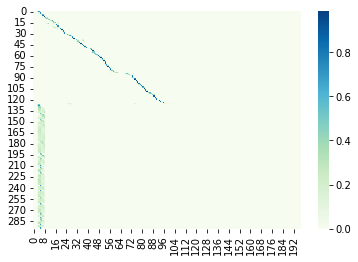

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    12: reducing learning rate of group 0 to 2.5600e-06.
running_loss 0.24535970404844157
Validation distance: 31.00165229885057

Epoch: 41/58


Train:   0%|          | 0/298 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
best_lev_dist = best_val_dist
tf_rate = 0.9
config['epochs']=checkpoint['epoch']


count=0

for epoch in range(config['epochs'], config['epochs']+30):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']+30))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot=train(model, train_loader, criterion, optimizer, teacher_forcing_rate=tf_rate)
    plot_attention(attention_plot)
    if epoch==0:
      past_valid_dist=10000000
    else:
      past_valid_dist=valid_dist
    valid_dist = validate(model, val_loader)  
    scheduler.step(valid_dist)
    
    #teacher forcing scheduler: ReduceTFOnPlateau
    #First 10-50 epochs
    
    if ( (valid_dist>past_valid_dist) and (abs(valid_dist-past_valid_dist)>=2) ):
      if count<=3:
        count+=1
      else:
        tf_rate=tf_rate*0.9
        count=0
    if tf_rate==0:
      tf_rate=1e-6
    #do augmentations and locked dropout later 
    #if I change architecture, cannot use torch saved models. But locked dropout is fine
    # lr Scheduler 
    #tf scheduler. just lower manually after every 5 epochs.
    #possible to 7.7 with 50 epochs 


    # Print your metrics
    print("running_loss",running_loss)
    print("Validation distance:", valid_dist)
    # Plot Attention 
    

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    #optimizer.step() already called within train so no need

    #first attempt: teacher forcing learner
    #second attempt:lock dropout and improved teacher forcing learner
    if valid_dist <= best_lev_dist:
        print("saving new best model")
        best_lev_dist = valid_dist
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': valid_dist, 
                  'epoch': epoch}, './second_attempt.pth')

        # Save your model checkpoint here

In [ ]:
PATH='./second_attempt.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
best_val_dist = checkpoint['val_dist']
past_valid_dist = checkpoint['val_dist']
config['epochs']=checkpoint['epoch']

best_lev_dist = best_val_dist
tf_rate = 0.5

print(optimizer) #previously 0.001
optimizer.param_groups[0]['lr']=1.28e-04
print(optimizer)

print("epoch is ",config['epochs'])
print(past_valid_dist)
print(best_val_dist)
print(tf_rate)


Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.000128
    weight_decay: 5e-06
)
Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.000128
    weight_decay: 5e-06
)
epoch is  31
29.699281609195403
29.699281609195403
0.5



Epoch: 30/59


Train:   0%|          | 0/298 [00:00<?, ?it/s]

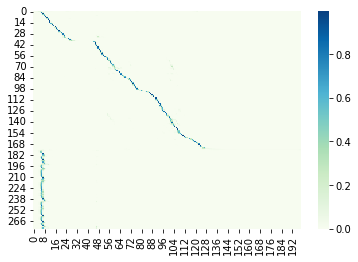

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.4208656659462308
Validation distance: 30.270617816091953

Epoch: 31/59


Train:   0%|          | 0/298 [00:00<?, ?it/s]

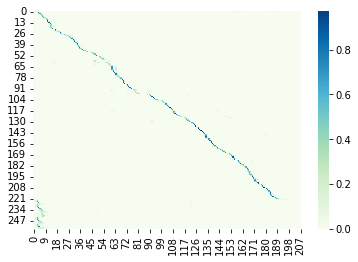

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 2.5600e-05.
running_loss 0.42743289800698325
Validation distance: 30.97262931034482

Epoch: 32/59


Train:   0%|          | 0/298 [00:00<?, ?it/s]

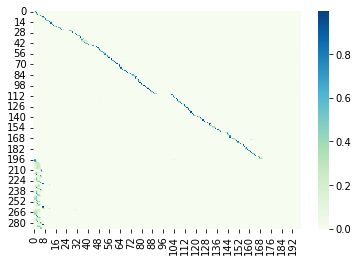

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.4322601634784033
Validation distance: 29.699281609195403
saving new best model

Epoch: 33/59


Train:   0%|          | 0/298 [00:00<?, ?it/s]

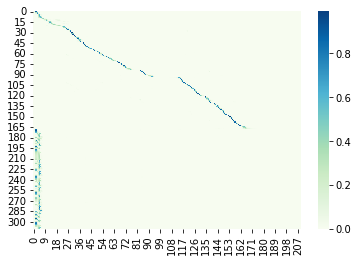

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.4279495856705928
Validation distance: 30.340158045977006

Epoch: 34/59


Train:   0%|          | 0/298 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:

#tf=0.7
count=0

for epoch in range(config['epochs'], config['epochs']+30):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']+30))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot=train(model, train_loader, criterion, optimizer, teacher_forcing_rate=tf_rate)
    plot_attention(attention_plot)
    if epoch==0:
      past_valid_dist=10000000
    else:
      past_valid_dist=valid_dist
    valid_dist = validate(model, val_loader)  
    scheduler.step(valid_dist)
    
    #teacher forcing scheduler: ReduceTFOnPlateau
    #First 10-50 epochs
    
    if ( (valid_dist>past_valid_dist) and (abs(valid_dist-past_valid_dist)>=0.8) ):
      if count<=3:
        count+=1
      else:
        tf_rate=tf_rate*0.8
        count=0
    if tf_rate==0:
      tf_rate=1e-6
    #do augmentations and locked dropout later 
    #if I change architecture, cannot use torch saved models. But locked dropout is fine
    # lr Scheduler 
    #tf scheduler. just lower manually after every 5 epochs.
    #possible to 7.7 with 50 epochs 


    # Print your metrics
    print("running_loss",running_loss)
    print("Validation distance:", valid_dist)
    # Plot Attention 
    

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    #optimizer.step() already called within train so no need

    #first attempt: teacher forcing learner
    #second attempt:lock dropout and improved teacher forcing learner
    if valid_dist <= best_lev_dist:
        print("saving new best model")
        best_lev_dist = valid_dist
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': valid_dist, 
                  'epoch': epoch}, './second_attempt.pth')

        # Save your model checkpoint here


Epoch: 32/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

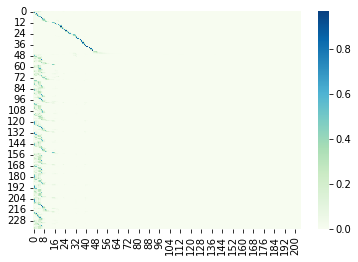

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 2.5600e-05.
running_loss 0.8329653438905742
Validation distance: 30.190086206896556

Epoch: 33/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

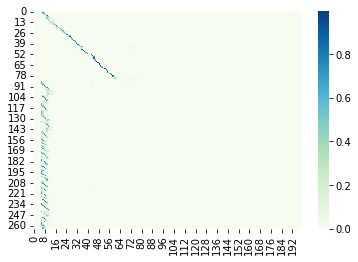

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.8237486385659083
Validation distance: 31.080818965517242

Epoch: 34/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

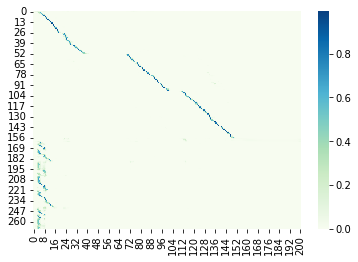

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    19: reducing learning rate of group 0 to 5.1200e-06.
running_loss 0.8392412390484906
Validation distance: 29.78505747126437

Epoch: 35/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

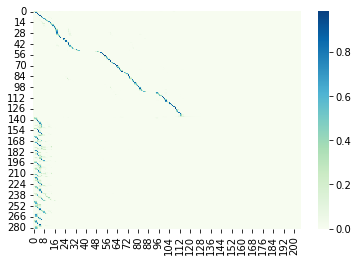

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.8403600268315949
Validation distance: 30.156321839080455

Epoch: 36/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

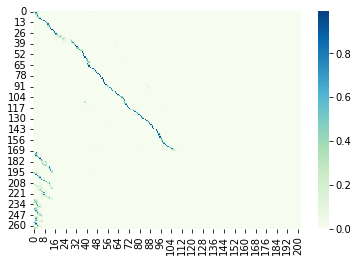

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    21: reducing learning rate of group 0 to 1.0240e-06.
running_loss 0.8191194384290068
Validation distance: 30.38972701149425

Epoch: 37/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

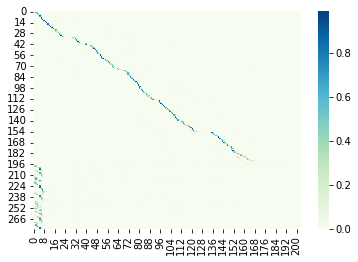

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.8296795029368177
Validation distance: 30.276364942528733

Epoch: 38/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

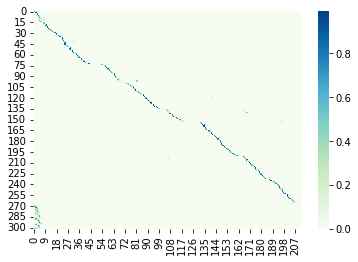

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    23: reducing learning rate of group 0 to 1.0000e-06.
running_loss 0.8339491587557248
Validation distance: 30.080531609195397

Epoch: 39/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:


count=0

for epoch in range(config['epochs'], config['epochs']+30):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']+30))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot=train(model, train_loader, criterion, optimizer, teacher_forcing_rate=tf_rate)
    plot_attention(attention_plot)
    if epoch==0:
      past_valid_dist=10000000
    else:
      past_valid_dist=valid_dist
    valid_dist = validate(model, val_loader)  
    scheduler.step(valid_dist)
    
    #teacher forcing scheduler: ReduceTFOnPlateau
    #First 10-50 epochs
    
    if ( (valid_dist>past_valid_dist) and (abs(valid_dist-past_valid_dist)>=0.8) ):
      if count<=3:
        count+=1
      else:
        tf_rate=tf_rate*0.8
        count=0
    if tf_rate==0:
      tf_rate=1e-6
    #do augmentations and locked dropout later 
    #if I change architecture, cannot use torch saved models. But locked dropout is fine
    # lr Scheduler 
    #tf scheduler. just lower manually after every 5 epochs.
    #possible to 7.7 with 50 epochs 


    # Print your metrics
    print("running_loss",running_loss)
    print("Validation distance:", valid_dist)
    # Plot Attention 
    

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    #optimizer.step() already called within train so no need

    #first attempt: teacher forcing learner
    #second attempt:lock dropout and improved teacher forcing learner
    if valid_dist <= best_lev_dist:
        print("saving new best model")
        best_lev_dist = valid_dist
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': valid_dist, 
                  'epoch': epoch}, './second_attempt.pth')

        # Save your model checkpoint here

In [ ]:
#error after adding locked dropout 
PATH='./second_attempt.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'],strict=False) #strict=False
best_val_dist = checkpoint['val_dist']
past_valid_dist = checkpoint['val_dist']
config['epochs']=checkpoint['epoch']

best_lev_dist = best_val_dist
tf_rate = 0.5

print(optimizer) #previously 0.001
optimizer.param_groups[0]['lr']=1.28e-04
print(optimizer)

print("epoch is ",config['epochs'])
print(past_valid_dist)
print(best_val_dist)
print(tf_rate)

Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.000128
    weight_decay: 5e-06
)
Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.000128
    weight_decay: 5e-06
)
epoch is  31
29.699281609195403
29.699281609195403
0.5



Epoch: 32/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

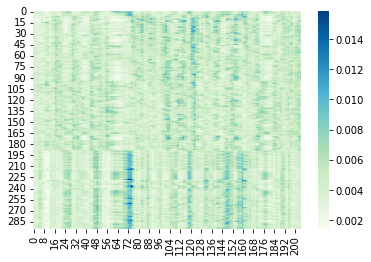

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 3.5411246006920836
Validation distance: 523.0192528735632

Epoch: 33/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

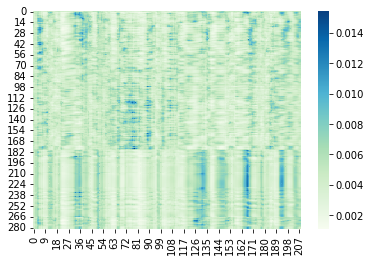

Val:   0%|          | 0/29 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:


count=0

for epoch in range(config['epochs'], config['epochs']+30):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']+30))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot=train(model, train_loader, criterion, optimizer, teacher_forcing_rate=tf_rate)
    plot_attention(attention_plot)
    if epoch==0:
      past_valid_dist=10000000
    else:
      past_valid_dist=valid_dist
    valid_dist = validate(model, val_loader)  
    scheduler.step(valid_dist)
    
    #teacher forcing scheduler: ReduceTFOnPlateau
    #First 10-50 epochs
    
    if ( (valid_dist>past_valid_dist) and (abs(valid_dist-past_valid_dist)>=0.8) ):
      if count<=3:
        count+=1
      else:
        tf_rate=tf_rate*0.8
        count=0
    if tf_rate==0:
      tf_rate=1e-6
    #do augmentations and locked dropout later 
    #if I change architecture, cannot use torch saved models. But locked dropout is fine
    # lr Scheduler 
    #tf scheduler. just lower manually after every 5 epochs.
    #possible to 7.7 with 50 epochs 


    # Print your metrics
    print("running_loss",running_loss)
    print("Validation distance:", valid_dist)
    # Plot Attention 
    

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    #optimizer.step() already called within train so no need

    #first attempt: teacher forcing learner
    #second attempt:lock dropout and improved teacher forcing learner
    if valid_dist <= best_lev_dist:
        print("saving new best model")
        best_lev_dist = valid_dist
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': valid_dist, 
                  'epoch': epoch}, './second_attempt.pth')

        # Save your model checkpoint here

In [ ]:
#doing this Dec 6th 6:25pm

#error after adding locked dropout 
PATH='./second_attempt.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'],strict=False) #strict=False
best_val_dist = checkpoint['val_dist']
past_valid_dist = checkpoint['val_dist']
config['epochs']=checkpoint['epoch']

best_lev_dist = best_val_dist
tf_rate = 0.7
print("Lr",config['lr'])
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               mode='min',  #min for minimising distance
                                                               factor=0.2,
                                                               patience=1,
                                                               min_lr=1e-6,
                                                               verbose=True)
print(optimizer) #previously 0.001
#optimizer.param_groups[0]['lr']=1.28e-04
print(optimizer)

print("epoch is ",config['epochs'])
print(past_valid_dist)
print(best_val_dist)
print(tf_rate)

#optimizer lr was too low for the model to learn even with locked dropout

Lr 0.001
Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 5e-06
)
Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 5e-06
)
epoch is  52
21.378807471264363
21.378807471264363
0.7



Epoch: 32/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

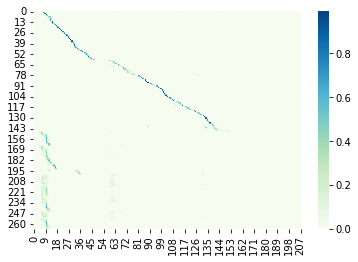

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.9833699695815976
Validation distance: 57.779525862068965

Epoch: 33/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

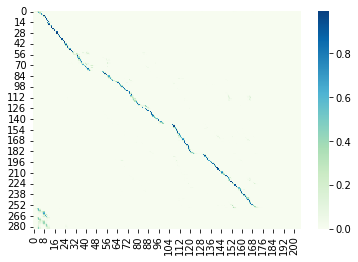

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.4236002042389556
Validation distance: 48.09224137931035

Epoch: 34/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

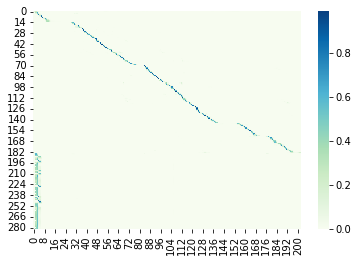

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.36522647638448935
Validation distance: 35.74913793103448

Epoch: 35/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

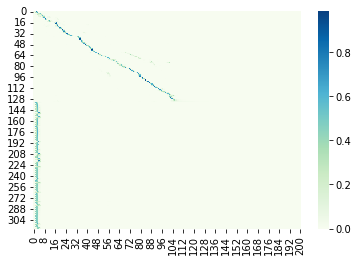

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.4175072732387773
Validation distance: 39.98333333333333

Epoch: 36/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

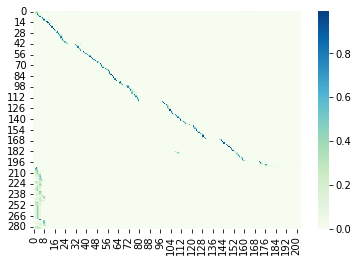

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.33575046772524814
Validation distance: 33.46752873563218

Epoch: 37/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

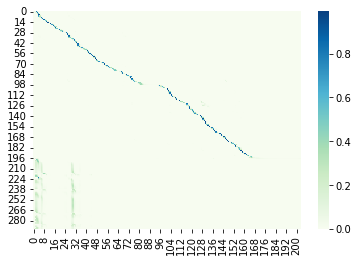

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.32050009511861227
Validation distance: 31.118821839080457

Epoch: 38/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

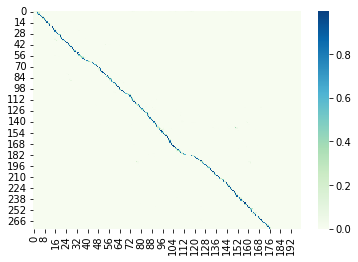

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.3042412738272008
Validation distance: 31.73814655172414

Epoch: 39/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

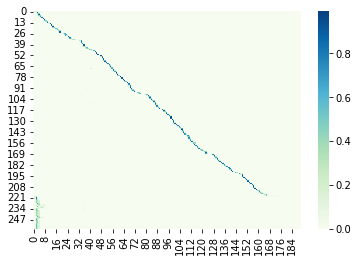

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.27940714849321635
Validation distance: 29.713218390804595

Epoch: 40/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

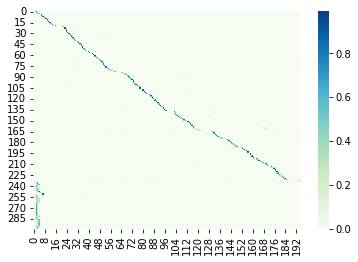

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.26249772490270984
Validation distance: 28.951724137931038
saving new best model

Epoch: 41/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

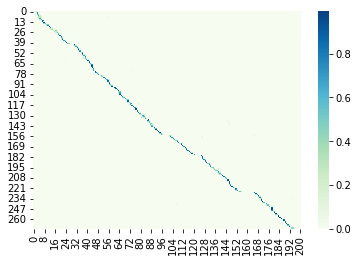

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.25175724318563536
Validation distance: 27.20689655172414
saving new best model

Epoch: 42/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

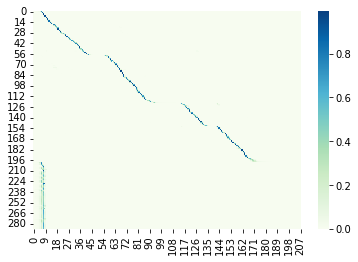

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.25557048928817644
Validation distance: 27.4701867816092

Epoch: 43/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

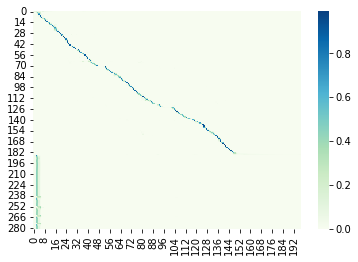

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.24812653150734484
Validation distance: 26.498850574712645
saving new best model

Epoch: 44/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

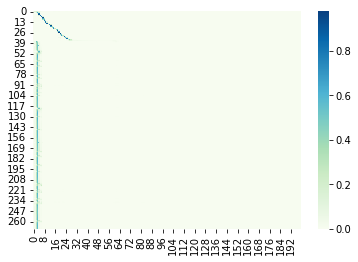

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.2436456586790565
Validation distance: 27.24956896551725

Epoch: 45/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

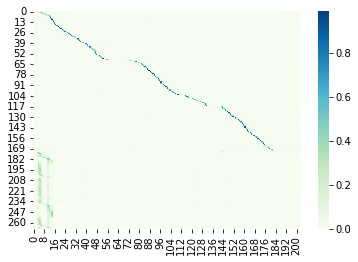

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.2298751605437106
Validation distance: 25.85316091954023
saving new best model

Epoch: 46/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

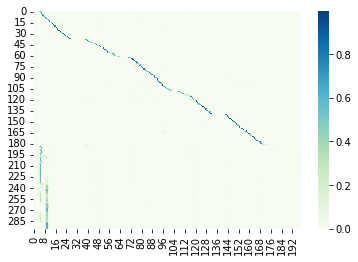

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.22927455804091973
Validation distance: 24.991451149425288
saving new best model

Epoch: 47/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

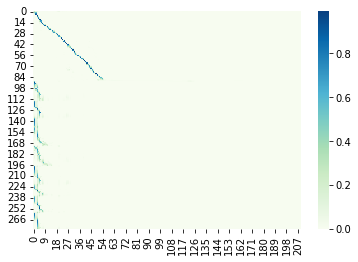

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.21858593626510378
Validation distance: 26.567313218390805

Epoch: 48/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

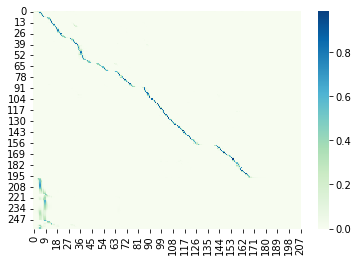

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 2.0000e-04.
running_loss 0.22310561506740198
Validation distance: 25.270689655172408

Epoch: 49/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

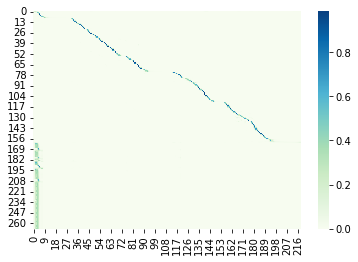

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.17962382283786799
Validation distance: 22.404310344827582
saving new best model

Epoch: 50/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

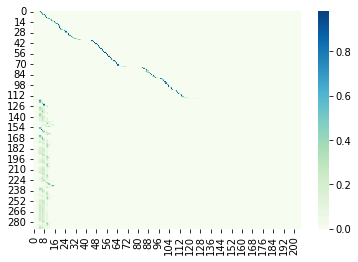

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.16852989520302555
Validation distance: 22.110129310344824
saving new best model

Epoch: 51/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

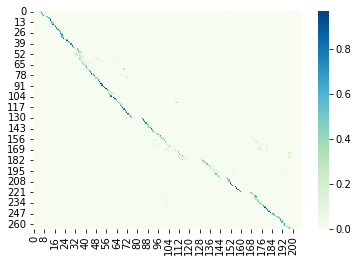

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.16467715697300514
Validation distance: 22.22119252873563

Epoch: 52/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

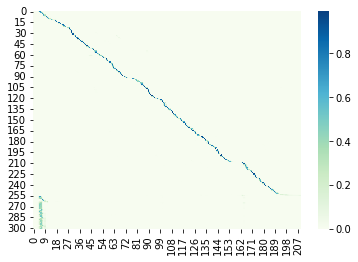

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    21: reducing learning rate of group 0 to 4.0000e-05.
running_loss 0.16163574734190167
Validation distance: 22.409410919540225

Epoch: 53/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

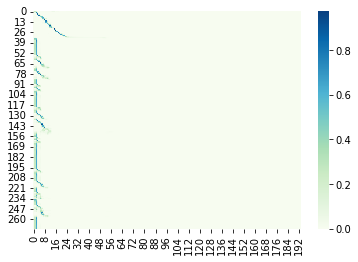

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.15410142756948536
Validation distance: 21.378807471264363
saving new best model

Epoch: 54/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

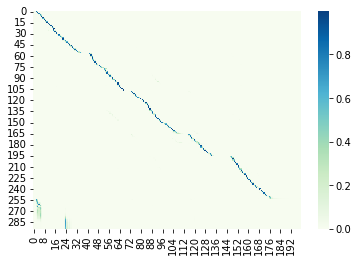

Val:   0%|          | 0/29 [00:00<?, ?it/s]

running_loss 0.15240321293373235
Validation distance: 21.6639367816092

Epoch: 55/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

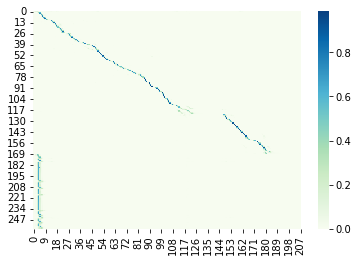

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch    24: reducing learning rate of group 0 to 8.0000e-06.
running_loss 0.15262342326893102
Validation distance: 21.497198275862072

Epoch: 56/61


Train:   0%|          | 0/298 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:


count=0

for epoch in range(config['epochs'], config['epochs']+30):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']+30))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot=train(model, train_loader, criterion, optimizer, teacher_forcing_rate=tf_rate)
    plot_attention(attention_plot)
    if epoch==0:
      past_valid_dist=10000000
    else:
      past_valid_dist=valid_dist
    valid_dist = validate(model, val_loader)  
    scheduler.step(valid_dist)
    
    #teacher forcing scheduler: ReduceTFOnPlateau
    #First 10-50 epochs

    #condition on epoch number
    #tf=1 
    #tf=
    
    if ( (valid_dist>past_valid_dist) and (abs(valid_dist-past_valid_dist)>=0.8) ):
      if count<=3:
        count+=1
      else:
        tf_rate=tf_rate*0.8
        count=0
    if tf_rate==0:
      tf_rate=1e-6
    #do augmentations and locked dropout later 
    #if I change architecture, cannot use torch saved models. But locked dropout is fine
    # lr Scheduler 
    #tf scheduler. just lower manually after every 5 epochs.
    #possible to 7.7 with 50 epochs 

    #with locked dropout in the beginning, it takes 50 epochs. 


    # Print your metrics
    print("running_loss",running_loss)
    print("Validation distance:", valid_dist)
    # Plot Attention 
    

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    #optimizer.step() already called within train so no need

    #first attempt: teacher forcing learner
    #second attempt:lock dropout and improved teacher forcing learner
    if valid_dist <= best_lev_dist:
        print("saving new best model")
        best_lev_dist = valid_dist
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': valid_dist, 
                  'epoch': epoch}, './second_attempt.pth')

        # Save your model checkpoint here

In [ ]:
#doing this Dec 7th 3:45pm

#error after adding locked dropout 
PATH='./second_attempt.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'],strict=False) #strict=False
best_val_dist = checkpoint['val_dist']
past_valid_dist = checkpoint['val_dist']
config['epochs']=checkpoint['epoch']

best_lev_dist = best_val_dist
valid_dist=best_val_dist
tf_rate = 0.5

config['lr']=0.001
print("Lr",config['lr'])
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               mode='min',  #min for minimising distance
                                                               factor=0.2,
                                                               patience=2,
                                                               min_lr=1e-6,
                                                               verbose=True)
print("optimizer")
optimizer.param_groups[0]['lr']=1.28e-05
print(optimizer) #previously 0.001

print("epoch is ",config['epochs'])
print(past_valid_dist)
print(best_val_dist)
print(tf_rate)

#optimizer lr was too low for the model to learn even with locked dropout

Lr 0.001
optimizer
Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1.28e-05
    weight_decay: 5e-06
)
epoch is  52
21.378807471264363
21.378807471264363
0.5


In [ ]:


count=0
count1=0
for epoch in range(config['epochs'], config['epochs']+30):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']+30))

    # Call train and validate 
    running_loss, running_perplexity, attention_plot=train(model, train_loader, criterion, optimizer, teacher_forcing_rate=tf_rate)
    plot_attention(attention_plot)
    if epoch==0:
      past_valid_dist=10000000
    else:
      past_valid_dist=valid_dist
    valid_dist = validate(model, val_loader)  
    scheduler.step(valid_dist)
    
    #teacher forcing scheduler: ReduceTFOnPlateau
    #First 10-50 epochs

    #condition on epoch number
    #tf=1 
    #tf=
    
    if ( (valid_dist>past_valid_dist) and (abs(valid_dist-past_valid_dist)>=0.8) ):
      if count<=3:
        count+=1
      else:
        tf_rate=tf_rate*0.8
        count=0
    if tf_rate==0:
      tf_rate=1e-6

    if count1>=12:
      tf_rate=0.5
    
    if count1>=24:
      tf_rate=0.4
    
    #do augmentations and locked dropout later 
    #if I change architecture, cannot use torch saved models. But locked dropout is fine
    # lr Scheduler 
    #tf scheduler. just lower manually after every 5 epochs.
    #possible to 7.7 with 50 epochs 

    #with locked dropout in the beginning, it takes 50 epochs. 


    # Print your metrics
    print("running_loss",running_loss)
    print("Validation distance:", valid_dist)
    # Plot Attention 
    

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    #optimizer.step() already called within train so no need

    #first attempt: teacher forcing learner
    #second attempt:lock dropout and improved teacher forcing learner
    if valid_dist <= best_lev_dist:
        print("saving new best model")
        best_lev_dist = valid_dist
        torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': valid_dist, 
                  'epoch': epoch}, './second_attempt.pth')

        # Save your model checkpoint here


Epoch: 53/82


Train:   0%|          | 0/298 [00:00<?, ?it/s]

RuntimeError: ignored

# Testing

In [ ]:
# Optional: Load your best model Checkpoint here
PATH='./second_attempt.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
best_val_dist = checkpoint['val_dist']
print(best_val_dist)

21.378807471264363


In [ ]:
# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle
def test(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    res=[]
    with torch.no_grad():
      for i, (x,lx) in enumerate(dataloader):
          # x, lx = x.cuda(), lx.cuda()
          x= x.cuda()
          predictions, attentions = model(x, lx)
          greedy_predictions = torch.argmax(predictions, dim=2)
          res_part=[]
          for char_pred in greedy_predictions:
              predicted_string = char_pred.tolist()
              predicted_string = indices_to_chars(predicted_string, VOCAB) #indices_to_chars(indices, vocab) returns list of characters
              res_part.append("".join(predicted_string))
          del x, lx
          torch.cuda.empty_cache()
          res.extend(res_part)

          #no need to calculate the distance
          #just concatentate
          
          batch_bar.update()

          torch.cuda.empty_cache()

      batch_bar.close()

    return res

In [ ]:
import csv
filename = "hw4p2_submission.csv"
submission_results=test(model, test_loader)
print(len(submission_results))


Val:   0%|          | 0/28 [00:00<?, ?it/s]

2620


In [ ]:
with open("hw4p2_submission.csv", "w+") as f:
        f.write("id,label\n")
        for i in range(len(submission_results)):
            f.write("{},{}\n".format(i, submission_results[i]))

In [ ]:
!kaggle competitions submit -c 11-785-f22-hw4p2 -f hw4p2_submission.csv -m "Message"


100% 291k/291k [00:02<00:00, 122kB/s]
Successfully submitted to Attention-Based Speech Recognition